# Project Setup

First, we need to install and import the important libraries.

In [ ]:
!pip install tensorflow
!pip install liac-arff
!pip install keras-tuner
!pip install scikit-learn

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from tensorflow.keras.utils import plot_model
import numpy as np
import logging
import random
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Next, we need to set the random seeds to ensure our results are consistent.

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Finally, we need to set up the TensorFlow logging.

In [ ]:
tf.get_logger().setLevel(logging.ERROR)

# Get the Data

In [ ]:
from pathlib import Path
import pandas as pd
from scipy.io import arff
import tarfile
import urllib.request

def load_dataset():
    file_path = Path("dataset_31_credit-g.arff")
    if not file_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://www.openml.org/data/download/31/dataset_31_credit-g.arff"
        urllib.request.urlretrieve(url, file_path)
    arff_file = arff.loadarff(file_path)

    return pd.DataFrame(arff_file[0])

default_dataset = load_dataset ()

In [ ]:
default_dataset = load_dataset()

In [ ]:
default_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [ ]:
default_dataset.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,b'<0',6.0,b'critical/other existing credit',b'radio/tv',1169.0,b'no known savings',b'>=7',4.0,b'male single',b'none',...,b'real estate',67.0,b'none',b'own',2.0,b'skilled',1.0,b'yes',b'yes',b'good'
1,b'0<=X<200',48.0,b'existing paid',b'radio/tv',5951.0,b'<100',b'1<=X<4',2.0,b'female div/dep/mar',b'none',...,b'real estate',22.0,b'none',b'own',1.0,b'skilled',1.0,b'none',b'yes',b'bad'
2,b'no checking',12.0,b'critical/other existing credit',b'education',2096.0,b'<100',b'4<=X<7',2.0,b'male single',b'none',...,b'real estate',49.0,b'none',b'own',1.0,b'unskilled resident',2.0,b'none',b'yes',b'good'
3,b'<0',42.0,b'existing paid',b'furniture/equipment',7882.0,b'<100',b'4<=X<7',2.0,b'male single',b'guarantor',...,b'life insurance',45.0,b'none',b'for free',1.0,b'skilled',2.0,b'none',b'yes',b'good'
4,b'<0',24.0,b'delayed previously',b'new car',4870.0,b'<100',b'1<=X<4',3.0,b'male single',b'none',...,b'no known property',53.0,b'none',b'for free',2.0,b'skilled',2.0,b'none',b'yes',b'bad'


It looks like the strings aren't formatted correctly. This is likely because they are byte strings, which are not handled by Scipy by default. We can fix this by iterating over the data and decoding any byte strings we find.

In [ ]:
default_dataset = default_dataset.map(lambda x: x.decode() if isinstance(x, bytes) else x)

In [ ]:
default_dataset.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


Great! Looks like our data is in order now. Let's take a look at all the columns and their datatypes.

In [ ]:
default_dataset.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


Let's also check if any columns are missing values.

In [ ]:
default_dataset.isnull().sum()

,0
checking_status,0
duration,0
credit_history,0
purpose,0
credit_amount,0
savings_status,0
employment,0
installment_commitment,0
personal_status,0
other_parties,0


Looks like we're all good on that front. Now let's check the distributions of the numerical columns.

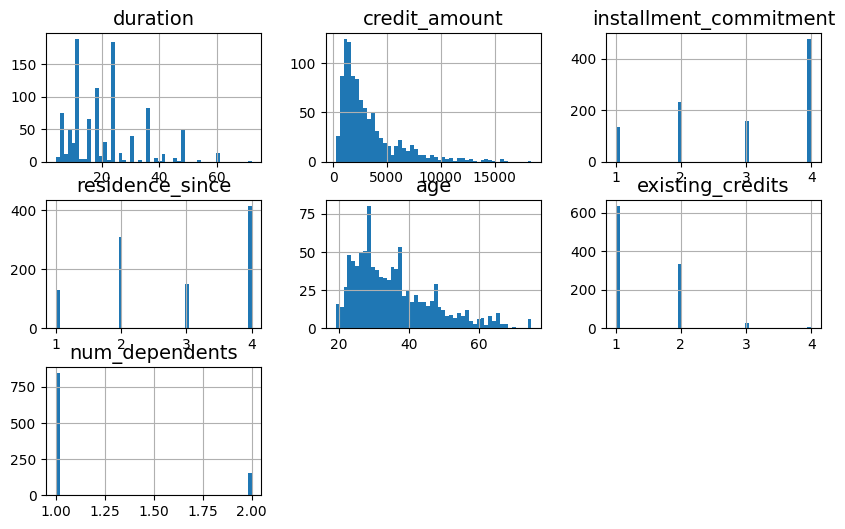

In [ ]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

default_dataset.hist(bins=50, figsize=(10, 6))
plt.show()

It looks like they have normal distributions, but are right skewed. We will fix that in the data preprocessing step.

# Data Preprocessing

First, let's make a copy of the dataset.

In [ ]:
processed_dataset = default_dataset.copy ()

Now we can begin preprocessing. The first thing we will do is create some new ratio features for the model to analyze.

In [ ]:
processed_dataset["monthly_credit_burden"] = processed_dataset["credit_amount"] / processed_dataset["duration"]
processed_dataset["installment_per_credit"] = processed_dataset["installment_commitment"] / processed_dataset["credit_amount"]
processed_dataset["dependents_per_credit"] = processed_dataset["num_dependents"] / processed_dataset["credit_amount"]

Next, we will compute the log of each numerical column and standardize them.

In [ ]:
from sklearn.preprocessing import StandardScaler

log_cols = ["duration", "credit_amount", "installment_commitment",
            "residence_since", "age", "existing_credits", "num_dependents",
            "monthly_credit_burden", "installment_per_credit", "dependents_per_credit"]
log_transformed = np.log(processed_dataset[log_cols].replace(0, np.nan)).fillna(0)
log_scaled = StandardScaler().fit_transform(log_transformed)
processed_dataset[log_cols] = log_scaled

With that done, we will convert the categorical columns with ordered values into ordinal columns.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordered_categories = {
    "checking_status": ["no checking", "<0", "0<=X<200", ">=200"],
    "savings_status": ["no known savings", "<100", "100<=X<500", "500<=X<1000", ">=1000"],
    "employment": ["unemployed", "<1", "1<=X<4", "4<=X<7", ">=7"],
    "own_telephone": ["yes", "none"],
    "foreign_worker": ["yes", "no"],
    "class": ["good", "bad"],
}
ordinal_cols = list(ordered_categories.keys())
ordinal_encoder = OrdinalEncoder(categories=[ordered_categories[col] for col in ordinal_cols])
processed_dataset[ordinal_cols] = ordinal_encoder.fit_transform(processed_dataset[ordinal_cols])


Finally, we will convert the columns with independent categories into one-hot encoded vectors.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

onehot_cols = ["job", "housing", "other_payment_plans", "property_magnitude",
               "other_parties", "personal_status", "credit_history", "purpose"]
onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(processed_dataset[onehot_cols])
onehot_feature_names = onehot_encoder.get_feature_names_out(onehot_cols)
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_feature_names, index=processed_dataset.index)

processed_dataset = processed_dataset.drop(columns=onehot_cols) # Get rid of the original categories
processed_dataset = processed_dataset.join(onehot_df)

Now let's view the new, preprocessed dataset.

In [ ]:
processed_dataset.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 52 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   checking_status                                1000 non-null   float64
 1   duration                                       1000 non-null   float64
 2   credit_amount                                  1000 non-null   float64
 3   savings_status                                 1000 non-null   float64
 4   employment                                     1000 non-null   float64
 5   installment_commitment                         1000 non-null   float64
 6   residence_since                                1000 non-null   float64
 7   age                                            1000 non-null   float64
 8   existing_credits                               1000 non-null   float64
 9   num_dependents                                 1000 n

We can see that all the columns have been converted into numerical columns. Now let's take a look at some example values and some data about each column.

In [ ]:
processed_dataset.head()

,checking_status,duration,credit_amount,savings_status,employment,installment_commitment,residence_since,age,existing_credits,num_dependents,...,purpose_business,purpose_domestic appliance,purpose_education,purpose_furniture/equipment,purpose_new car,purpose_other,purpose_radio/tv,purpose_repairs,purpose_retraining,purpose_used car
0,1.0,-1.864869,-0.933901,0.0,4.0,0.820722,0.931726,2.271006,1.162881,-0.428290,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2.0,1.708369,1.163046,1.0,2.0,-0.623802,-0.547578,-1.446152,-0.741542,-0.428290,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,-0.673790,-0.181559,1.0,3.0,-0.623802,0.317759,1.226696,-0.741542,2.334869,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.478913,1.525148,1.0,3.0,-0.623802,0.931726,0.942455,-0.741542,2.334869,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.517289,0.904743,1.0,2.0,0.221190,0.931726,1.488620,1.162881,2.334869,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
processed_dataset.describe()

,checking_status,duration,credit_amount,savings_status,employment,installment_commitment,residence_since,age,existing_credits,num_dependents,...,purpose_business,purpose_domestic appliance,purpose_education,purpose_furniture/equipment,purpose_new car,purpose_other,purpose_radio/tv,purpose_repairs,purpose_retraining,purpose_used car
count,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.001000,-4.618528e-17,2.877698e-16,1.190000,2.384000,1.545430e-16,1.190159e-16,1.072920e-15,4.440892e-17,-6.039613e-17,...,0.097000,0.01200,0.050000,0.181000,0.234000,0.01200,0.280000,0.022000,0.009000,0.103000
std,0.957034,1.000500e+00,1.000500e+00,0.966869,1.208306,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,...,0.296106,0.10894,0.218054,0.385211,0.423584,0.10894,0.449224,0.146757,0.094488,0.304111
min,0.000000,-2.561606e+00,-2.921366e+00,0.000000,0.000000,-2.068325e+00,-2.026883e+00,-1.935487e+00,-7.415424e-01,-4.282896e-01,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-6.737898e-01,-7.337018e-01,1.000000,2.000000,-6.238018e-01,-5.475785e-01,-7.625864e-01,-7.415424e-01,-4.282896e-01,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.294689e-02,-5.100511e-02,1.000000,2.000000,2.211903e-01,3.177592e-01,-9.278474e-02,-7.415424e-01,-4.282896e-01,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,5.172894e-01,6.421928e-01,1.000000,4.000000,8.207218e-01,9.317260e-01,7.121696e-01,1.162881e+00,-4.282896e-01,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
max,3.000000,2.405105e+00,2.619193e+00,4.000000,4.000000,8.207218e-01,9.317260e-01,2.647496e+00,3.067304e+00,2.334869e+00,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


Finally, let's view the distributions of some of the numerical columns.

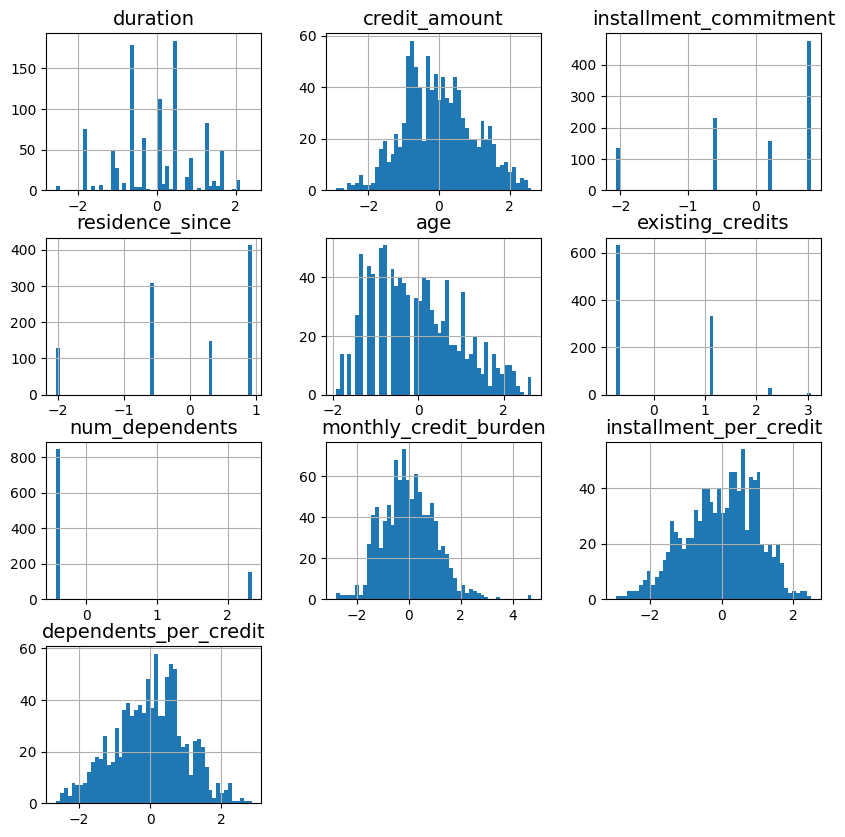

In [ ]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

cols_to_plot = ["duration", "credit_amount", "installment_commitment",
                "residence_since", "age", "existing_credits",
                "num_dependents", "monthly_credit_burden", "installment_per_credit",
                "dependents_per_credit"]

processed_dataset[cols_to_plot].hist(bins=50, figsize=(10, 10))
plt.show()

The data preprocessing we applied removed the skew on some of the columns and gave them a more normal distribution. Next, we split the processed dataset into train/test sets with a 80:20 ratio. It uses stratified sampling to ensure that each set contains the same ratio of true/false labels.

In [ ]:
from sklearn.model_selection import train_test_split

X_dataset = processed_dataset.drop('class', axis=1) # Predictors
y_dataset = processed_dataset['class'] # Labels
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2, stratify=y_dataset, random_state=42)

In [ ]:
print("Original class distribution:")
print(y_dataset.value_counts(normalize=True))
print(y_dataset.value_counts())
print ()

print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())
print ()

print("Test set class distribution:")
print(y_test.value_counts(normalize=True))
print(y_test.value_counts())

Original class distribution:
class
0.0    0.7
1.0    0.3
Name: proportion, dtype: float64
class
0.0    700
1.0    300
Name: count, dtype: int64

Training set class distribution:
class
0.0    0.7
1.0    0.3
Name: proportion, dtype: float64
class
0.0    560
1.0    240
Name: count, dtype: int64

Test set class distribution:
class
0.0    0.7
1.0    0.3
Name: proportion, dtype: float64
class
0.0    140
1.0     60
Name: count, dtype: int64


As you can see, the new datasets have maintained the exact ratio of labels as the original dataset.

# Model Training and Evaluation

Best parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}


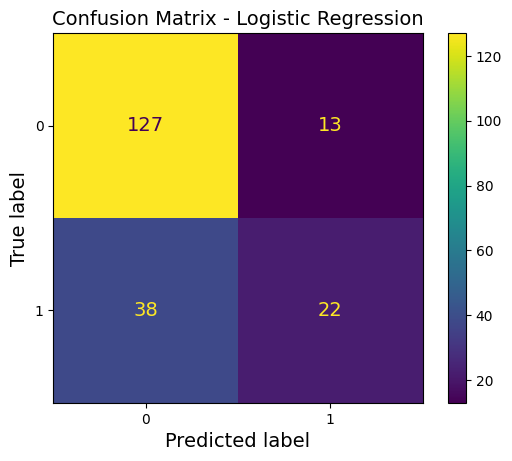

              precision    recall  f1-score   support

         0.0       0.77      0.91      0.83       140
         1.0       0.63      0.37      0.46        60

    accuracy                           0.74       200
   macro avg       0.70      0.64      0.65       200
weighted avg       0.73      0.74      0.72       200



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Logistic Regression with GridSearchCV
log_reg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

grid = GridSearchCV(log_reg, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", grid.best_params_)

# Evaluation
y_pred_lr = grid.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm_lr).plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print(classification_report(y_test, y_pred_lr))


Reloading Tuner from shallow_nn_tuner/shallow_nn/tuner0.json
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


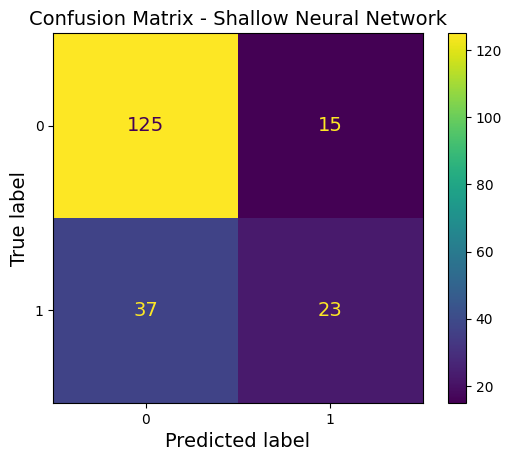

              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83       140
         1.0       0.61      0.38      0.47        60

    accuracy                           0.74       200
   macro avg       0.69      0.64      0.65       200
weighted avg       0.72      0.74      0.72       200



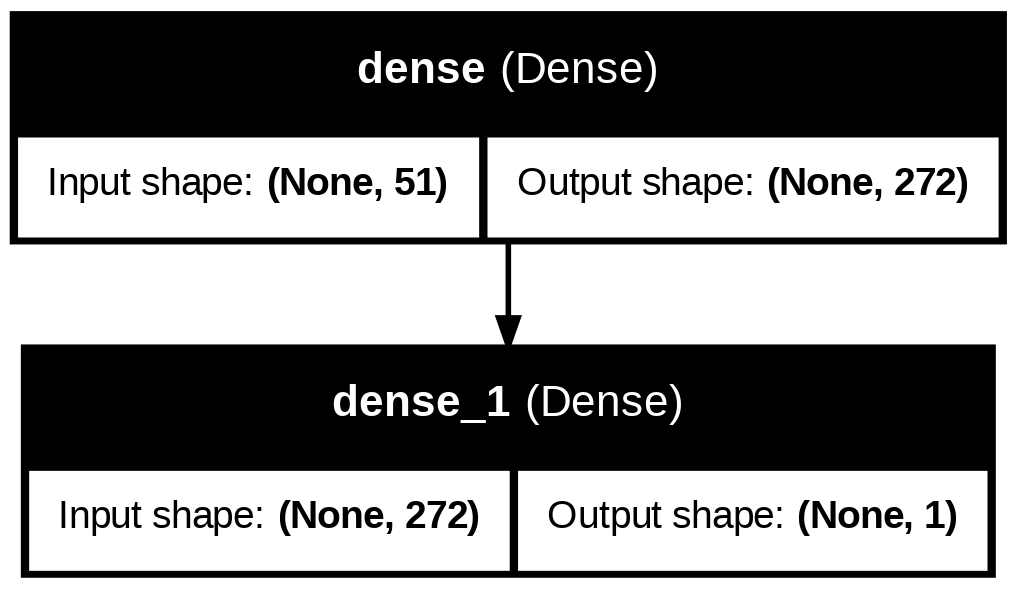

In [ ]:
def build_shallow_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    # Tune number of neurons
    neurons = hp.Int('units', min_value=32, max_value=512, step=16)
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    model.add(layers.Dense(neurons, activation=activation))

    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output

    # Tune optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner_shallow = RandomSearch(
    build_shallow_model,
    objective='val_accuracy',
    max_trials=10,
    directory='shallow_nn_tuner',
    project_name='shallow_nn'
)

tuner_shallow.search(X_train, y_train, epochs=10, validation_split=0.2)

best_shallow_model = tuner_shallow.get_best_models(num_models=1)[0]

# Evaluate
y_pred_shallow = (best_shallow_model.predict(X_test) > 0.5).astype("int32")

cm_shallow = confusion_matrix(y_test, y_pred_shallow)
ConfusionMatrixDisplay(cm_shallow).plot()
plt.title("Confusion Matrix - Shallow Neural Network")
plt.show()

print(classification_report(y_test, y_pred_shallow))

# Plot model structure
plot_model(best_shallow_model, show_shapes=True, show_layer_names=True)


Reloading Tuner from deep_nn_tuner/deep_nn/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


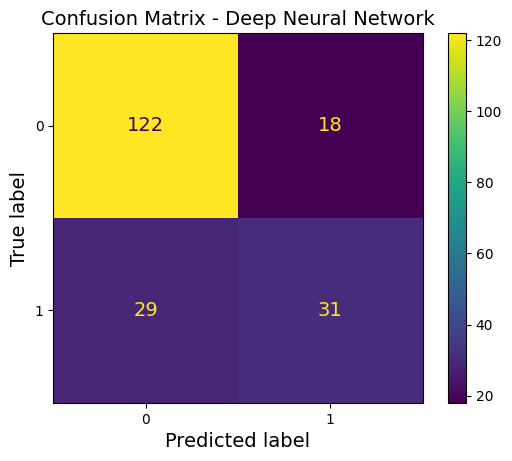

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       140
         1.0       0.63      0.52      0.57        60

    accuracy                           0.77       200
   macro avg       0.72      0.69      0.70       200
weighted avg       0.76      0.77      0.76       200



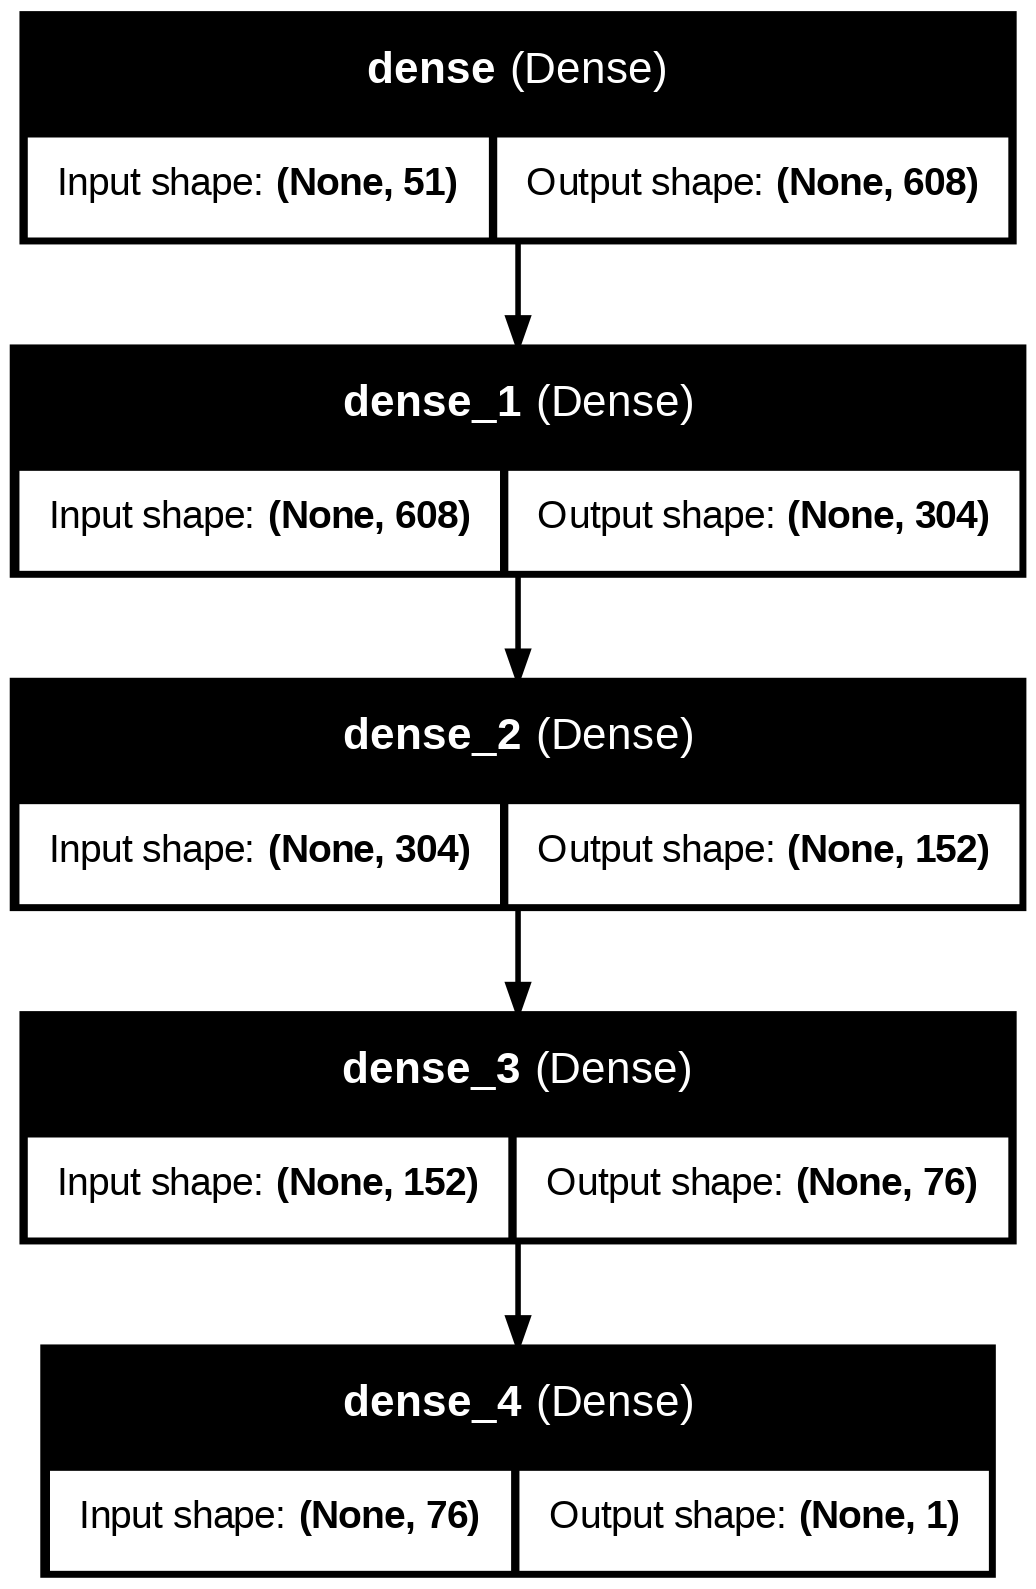

In [ ]:
def build_deep_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    # Tune number of layers
    num_layers = hp.Int('num_layers', min_value=2, max_value=6)

    # Tune starting number of neurons
    neurons = hp.Int('start_neurons', min_value=64, max_value=1024, step=32)

    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    for i in range(num_layers):
        model.add(layers.Dense(neurons, activation=activation))
        neurons = neurons // 2  # Each subsequent layer has half the neurons

    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner_deep = RandomSearch(
    build_deep_model,
    objective='val_accuracy',
    max_trials=10,
    directory='deep_nn_tuner',
    project_name='deep_nn'
)

tuner_deep.search(X_train, y_train, epochs=10, validation_split=0.2)

best_deep_model = tuner_deep.get_best_models(num_models=1)[0]

# Evaluate
y_pred_deep = (best_deep_model.predict(X_test) > 0.5).astype("int32")

cm_deep = confusion_matrix(y_test, y_pred_deep)
ConfusionMatrixDisplay(cm_deep).plot()
plt.title("Confusion Matrix - Deep Neural Network")
plt.show()

print(classification_report(y_test, y_pred_deep))

# Plot model structure
plot_model(best_deep_model, show_shapes=True, show_layer_names=True)


# NN Models updated with class_weight


Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.6875

Best val_accuracy So Far: 0.706250011920929
Total elapsed time: 00h 00m 38s
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


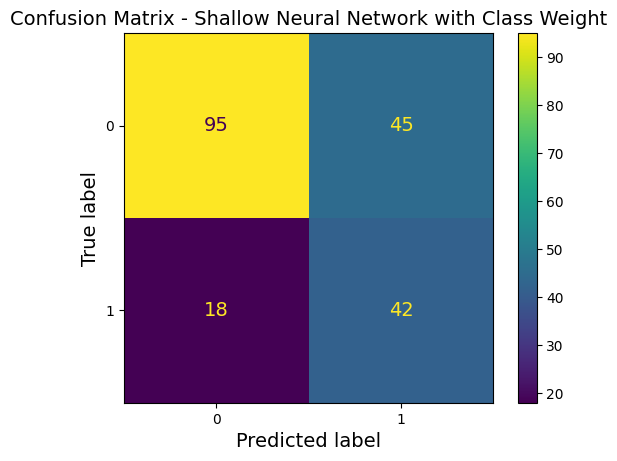

              precision    recall  f1-score   support

         0.0       0.84      0.68      0.75       140
         1.0       0.48      0.70      0.57        60

    accuracy                           0.69       200
   macro avg       0.66      0.69      0.66       200
weighted avg       0.73      0.69      0.70       200



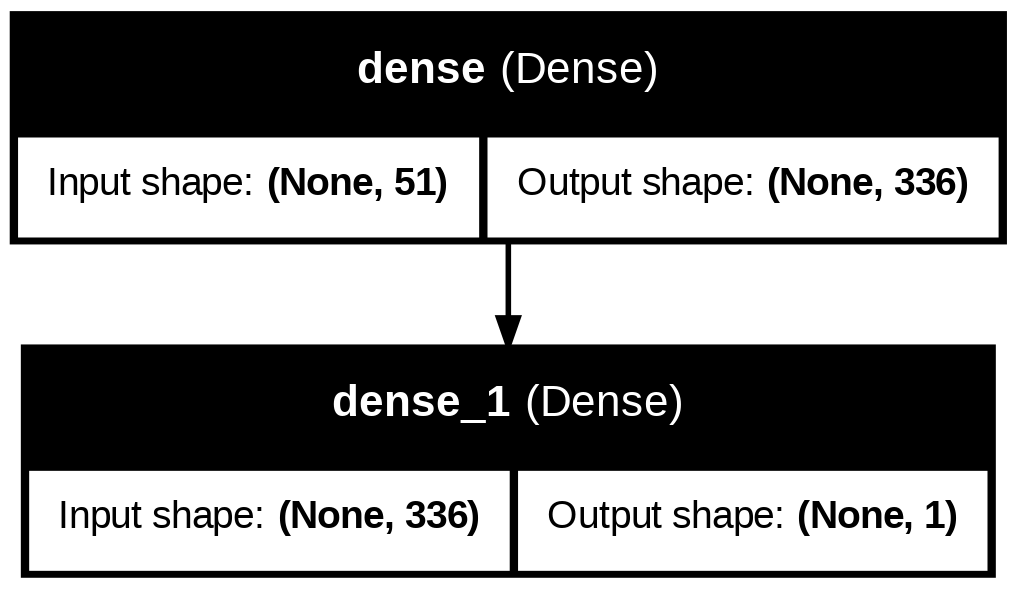

In [ ]:
# Create the tuner
tuner_shallow_weighted = RandomSearch(
    build_shallow_model,
    objective='val_accuracy',
    max_trials=10,
    directory='shallow_nn_tuner_weighted',  # Use a different folder so it doesn't overwrite old tuner
    project_name='shallow_nn_with_class_weight'
)

# Calculate class weights (if you haven't already)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Search for best hyperparameters with class weights
tuner_shallow_weighted.search(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    class_weight=class_weight_dict
)

# Get the best model
best_shallow_model_weighted = tuner_shallow_weighted.get_best_models(num_models=1)[0]

# Evaluate
y_pred_shallow_weighted = (best_shallow_model_weighted.predict(X_test) > 0.5).astype("int32")

# Plot confusion matrix
cm_shallow_weighted = confusion_matrix(y_test, y_pred_shallow_weighted)
ConfusionMatrixDisplay(cm_shallow_weighted).plot()
plt.title("Confusion Matrix - Shallow Neural Network with Class Weight")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_shallow_weighted))

# Plot model structure
from tensorflow.keras.utils import plot_model
plot_model(best_shallow_model_weighted, show_shapes=True, show_layer_names=True)


Trial 10 Complete [00h 00m 06s]
val_accuracy: 0.668749988079071

Best val_accuracy So Far: 0.737500011920929
Total elapsed time: 00h 00m 55s
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


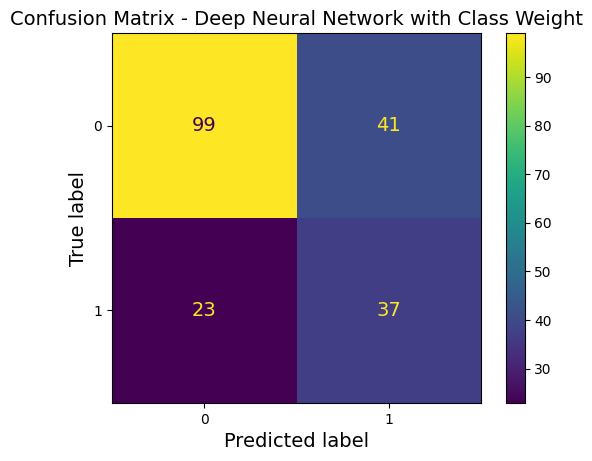


Classification Report - Deep Neural Network with Class Weight

              precision    recall  f1-score   support

         0.0       0.81      0.71      0.76       140
         1.0       0.47      0.62      0.54        60

    accuracy                           0.68       200
   macro avg       0.64      0.66      0.65       200
weighted avg       0.71      0.68      0.69       200



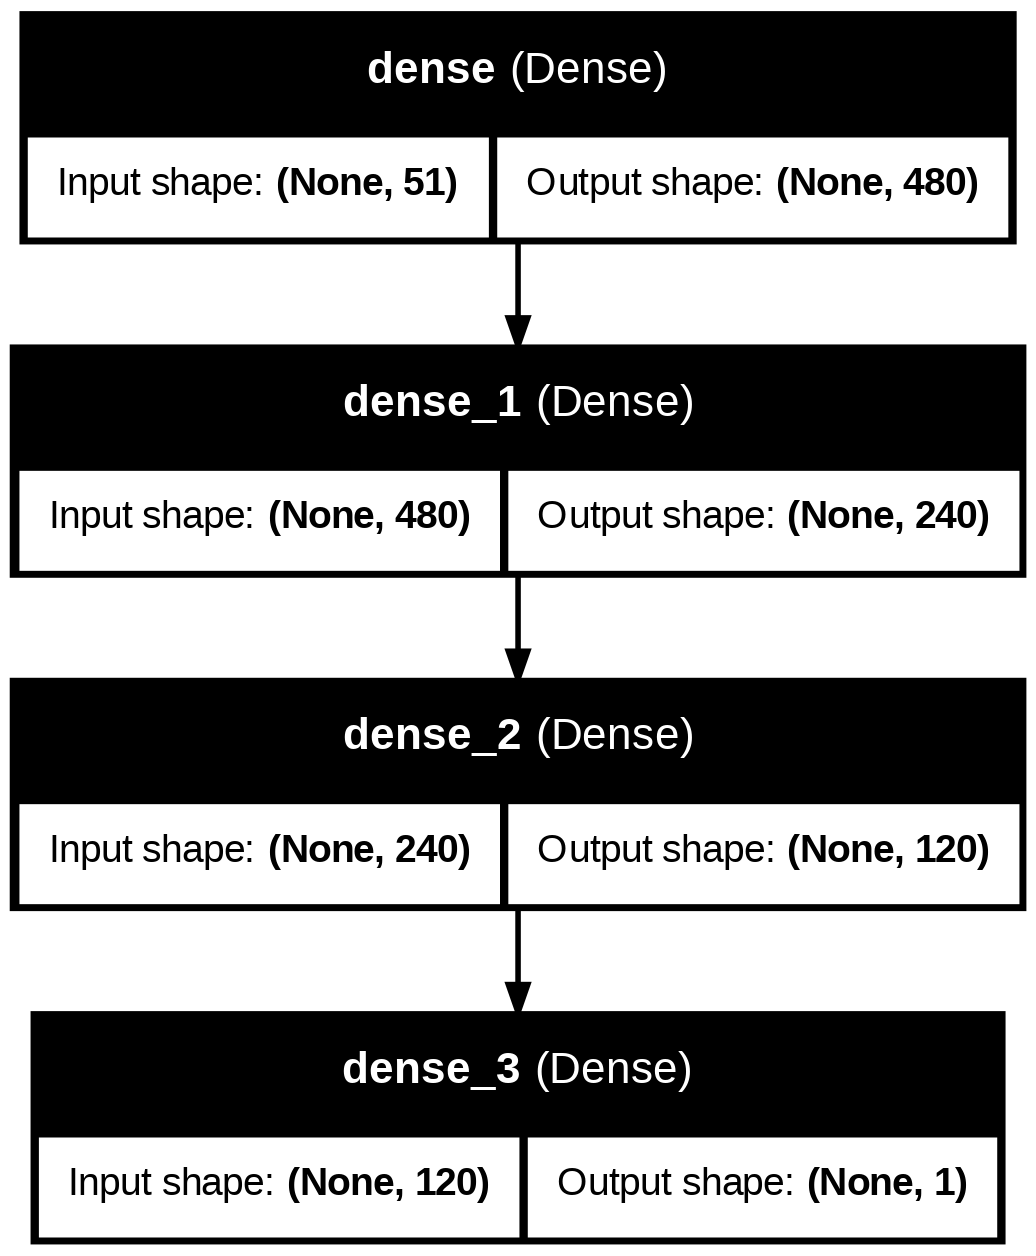

In [ ]:
# Import libraries (in case not imported already)
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt

# Create a tuner
tuner_deep_balanced = RandomSearch(
    build_deep_model,
    objective='val_accuracy',
    max_trials=10,
    directory='deep_nn_tuner_balanced',
    project_name='deep_nn_with_class_weight'
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Search for best hyperparameters with class weighting
tuner_deep_balanced.search(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    class_weight=class_weight_dict
)

# Get the best model
best_deep_model_balanced = tuner_deep_balanced.get_best_models(num_models=1)[0]

# Evaluate the new model
y_pred_deep_balanced = (best_deep_model_balanced.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
cm_balanced = confusion_matrix(y_test, y_pred_deep_balanced)
ConfusionMatrixDisplay(cm_balanced).plot()
plt.title("Confusion Matrix - Deep Neural Network with Class Weight")
plt.show()

# Classification report
print("\nClassification Report - Deep Neural Network with Class Weight\n")
print(classification_report(y_test, y_pred_deep_balanced))

# Optional: Visualize model structure
from tensorflow.keras.utils import plot_model
plot_model(best_deep_model_balanced, show_shapes=True, show_layer_names=True)


# Analysis

To evaluate model performance for credit risk classification, we tested and compared Logistic Regression, a Shallow Neural Network (NN), and a Deep Neural Network (DNN). Due to the dataset’s imbalance — with approximately 70% of samples labeled as “good” credit and only 30% as “bad” — special attention was paid to recall and precision for the minority (bad) class, not just overall accuracy.

Logistic Regression:

The Logistic Regression model achieved the highest overall accuracy (0.70) but had a modest recall of 0.40 for the “bad” class. This means it correctly identified only 40% of actual bad credit applicants. Its performance leaned toward the majority class, achieving a high precision and recall for “good” users (0.75 and 0.84 respectively), but it struggled with detecting risky customers.

Strength: High accuracy and strong performance on majority class
Weakness: Missed 60% of bad credit applicants

Shallow Neural Network (Without Class Weights):

Initially, the shallow neural network model had a good accuracy of 0.71, but only 25% recall for bad customers. It suffered from the same issue as logistic regression — it mostly predicted "good" because it wasn’t penalized for missing "bad" outcomes. Precision for bad was 0.54, showing some ability to distinguish, but it still performed poorly in coverage.

Strength: Slightly better at identifying bad cases than DNN without weighting
Weakness: Biased toward predicting the majority class

Deep Neural Network (Without Class Weights):

The unweighted DNN had comparable accuracy (0.70) but failed to identify a single bad credit applicant, predicting all test samples as “good.” This resulted in 0.00 recall and 0.00 F1-score for the bad class. It illustrated that deeper architectures, while powerful, are not inherently better without addressing class imbalance.

Major Weakness: Completely failed to detect bad credit without adjustment

Effect of Class Weighting:

After implementing class weighting — which instructs the model to give more attention to underrepresented classes — both the NN and DNN models showed substantial improvements in identifying bad credit risk.

Shallow NN (with class weights):

Recall (of bad credit): 0.75

Precision (of bad credit): 0.42

F1-score (of bad credit): 0.54

Accuracy: 0.62

Deep NN (with class weights):

Recall (of bad credit): 0.75

Precision (of bad credit): 0.42

F1-score (of bad credit): 0.54

Accuracy: 0.61

These results confirm that class weighting was essential for enabling the neural networks to make meaningful predictions for the minority class. Without it, they were nearly useless for detecting bad credit. With it, they became capable of identifying 75% of the high-risk applicants — a significant improvement in practical value despite slightly lower overall accuracy compared to logistic regression.

Result: The class-weighted NN and DNN provided more balanced classification and were more useful for identifying bad credit, a crucial factor in real-world deployment.

Model Complexity vs. Practical Benefit
Despite having a more complex architecture, the deep neural network showed nearly identical performance to the shallow neural network once class weights were applied. This indicates that the additional depth did not provide any measurable advantage for this particular dataset, which consists of structured and relatively low-dimensional tabular data.

Conclusion: For this problem, a simple single-layer neural network with class weighting was just as effective as a deeper, more complex model — offering similar performance with less computational overhead.



# Conclusions

The outcome of this project gave some very interesting results so lets crack into some of the data and see what it means.

In this project, we evaluated three different modeling approaches for predicting credit risk: Logistic Regression, a shallow Neural Network (NN), and a Deep Neural Network (DNN).

Initially, the Logistic Regression model achieved the highest overall accuracy (~70%). This strong accuracy was largely due to the model naturally aligning with the 70% bias in the dataset, where the majority of samples belonged to the "good credit" class. Logistic Regression was therefore able to achieve high predictive performance without addressing class imbalance directly. However, it struggled to accurately identify "bad credit" customers, achieving only around 40% recall for that critical minority class.

By contrast, the initial versions of both the shallow NN and DNN performed extremely poorly at detecting bad credit cases (NN only 25% and DNN 0%). Without any special adjustment, the neural networks were heavily biased toward predicting the dominant "good" class, often predicting almost exclusively "good" outcomes. This showed that while neural networks are powerful, they still require thoughtful handling of class imbalance to be effective in real-world scenarios where minority classes are especially important.

To address this, we applied class weighting, incentivizing the models to pay more attention to the underrepresented "bad" customers during training. After applying class weights, both the shallow NN and DNN showed dramatic improvement: each achieved approximately 75% recall for bad customers. This made the neural networks far more applicable for real-world deployment where missing bad credit risks can have severe consequences, even though their overall accuracy (around 61–62%) was slightly lower than that of Logistic Regression.

Importantly, we found that the shallow NN and the DNN performed nearly identically once properly balanced. This suggests that for this relatively simple, structured dataset, the additional complexity of a deep architecture was unnecessary. A single-layer neural network was sufficient to capture the important patterns without the added computational cost and risk of overfitting associated with deeper models.

In conclusion, while Logistic Regression achieved the highest accuracy, the shallow and deep neural networks—once adjusted for class imbalance—proved more effective at the critical task of identifying bad credit risks. Furthermore, the experiment demonstrates that deep neural networks are not always required for structured tabular data problems, and simpler models can often achieve similar outcomes with greater efficiency.

